# Forward gravity modelling of prisms of topograph

This notebook is based on the [Harmonica tutorial at Transform 2021](https://github.com/fatiando/transform21).

## Import packages

Start by loading everything we need.

In [1]:
# The standard Python science stack
from __future__ import annotations

import boule as bl
import harmonica as hm
import numpy as np
import pandas as pd

# The Fatiando stack
import pooch

# Plotting maps using GMT
import pygmt

# For projections (wrapped for Proj)
import pyproj
import pyvista
import verde as vd
import xarray as xr

## Data from the Bushveld Igneous Complex (South Africa)

We can use [Pooch](https://www.fatiando.org/pooch) to download data files from anywhere on the web. Let's download some public domain gravity data from the Bushveld Igneous Complex that we have on some GitHub repositories.

In [2]:
url_grav = "https://github.com/fatiando/2021-gsh/raw/main/data/bushveld_gravity.csv"
md5_grav = "md5:45539f7945794911c6b5a2eb43391051"

url_topo = (
    "https://github.com/fatiando/transform21/raw/main/data/bushveld_topography.nc"
)
md5_topo = "md5:62daf6a114dda89530e88942aa3b8c41"

In [3]:
path_grav = pooch.retrieve(url_grav, known_hash=md5_grav)
path_topo = pooch.retrieve(url_topo, known_hash=md5_topo)

print(path_grav)
print(path_topo)

C:\Users\matthewt\AppData\Local\pooch\pooch\Cache\f9087e49a3b8e83d4e2affba9882d9ad-bushveld_gravity.csv
C:\Users\matthewt\AppData\Local\pooch\pooch\Cache\da3d295d727d76ff80f092a51df3d2fa-bushveld_topography.nc


Use Pandas to read the gravity data from the CSV file. Reproject into meters.

In [29]:
data = pd.read_csv(path_grav)
# Project to mercator
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data["easting"], data["northing"] = projection(data.longitude, data.latitude)
data

latitude  longitude  elevation    gravity       easting      northing
0    -26.26334   25.01500    1230.16  978681.38  2.526066e+06 -2.733052e+06
1    -26.38713   25.01932    1297.00  978669.02  2.526503e+06 -2.746924e+06
2    -26.39667   25.02499    1304.84  978669.28  2.527075e+06 -2.747994e+06
3    -26.07668   25.04500    1165.24  978681.08  2.529096e+06 -2.712163e+06
4    -26.35001   25.07668    1262.47  978665.19  2.532295e+06 -2.742763e+06
...        ...        ...        ...        ...           ...           ...
3872 -23.86333   31.51500     300.53  978776.85  3.182450e+06 -2.466945e+06
3873 -23.30000   31.52499     280.72  978798.55  3.183459e+06 -2.405224e+06
3874 -23.19333   31.54832     245.67  978803.55  3.185814e+06 -2.393567e+06
3875 -23.84833   31.57333     226.77  978808.44  3.188340e+06 -2.465298e+06
3876 -23.00000   31.37500     285.59  978734.77  3.168312e+06 -2.372463e+06

[3877 rows x 6 columns]

Calculate region boundaries and map projection in meters

In [5]:
# set figure height, width and map scale
fig_height = 180  # in mm

spacing = 10000

e, w = data.easting.min() // spacing * spacing, data.easting.max() // spacing * spacing
n, s = (
    data.northing.min() // spacing * spacing,
    data.northing.max() // spacing * spacing,
)
# e, w = data.easting.min(), data.easting.max()
# n, s = data.northing.min(), data.northing.max()
fig_width = fig_height * (w - e) / (s - n)
fig_ratio = (s - n) / (fig_height / 1000)
# Make a GMT region string and projection strings in both ESPG3031 and Lat/Lon
fig_reg = f"{e}/{w}/{n}/{s}"
fig_proj = f"x1:{fig_ratio}"
fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"
fig_reg

'2520000.0/3230000.0/-2820000.0/-2380000.0'

Use xarray to read the topography data from the netCDF file and re-project into meters

In [6]:
topography = xr.load_dataarray(path_topo)

# projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
# da_topo = vd.project_grid(topography, projection=projection)

# Convert to pandas dataframe
df_topo = topography.to_dataframe().reset_index()
# Project to mercator
projection = pyproj.Proj(proj="merc", lat_ts=df_topo.latitude.mean())
df_topo["x"], df_topo["y"] = projection(df_topo.longitude, df_topo.latitude)

df_topo = pygmt.blockmedian(
    data=df_topo[["x", "y", "bedrock"]], region=fig_reg, spacing=spacing
)
da_topo = pygmt.surface(data=df_topo, region=fig_reg, spacing=spacing, registration="g")

pygmt.grdinfo(da_topo)

surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.


': Title: \n: Command: \n: Remark: \n: Gridline node registration used [Cartesian grid]\n: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7\n: x_min: 2520000 x_max: 3230000 x_inc: 10000 name: x n_columns: 72\n: y_min: -2820000 y_max: -2380000 y_inc: 10000 name: y n_rows: 45\n: v_min: 90.652961731 v_max: 2126.38867188 name: z\n: scale_factor: 1 add_offset: 0\n: format: classic\n'

Use pygmt to plot the data.

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


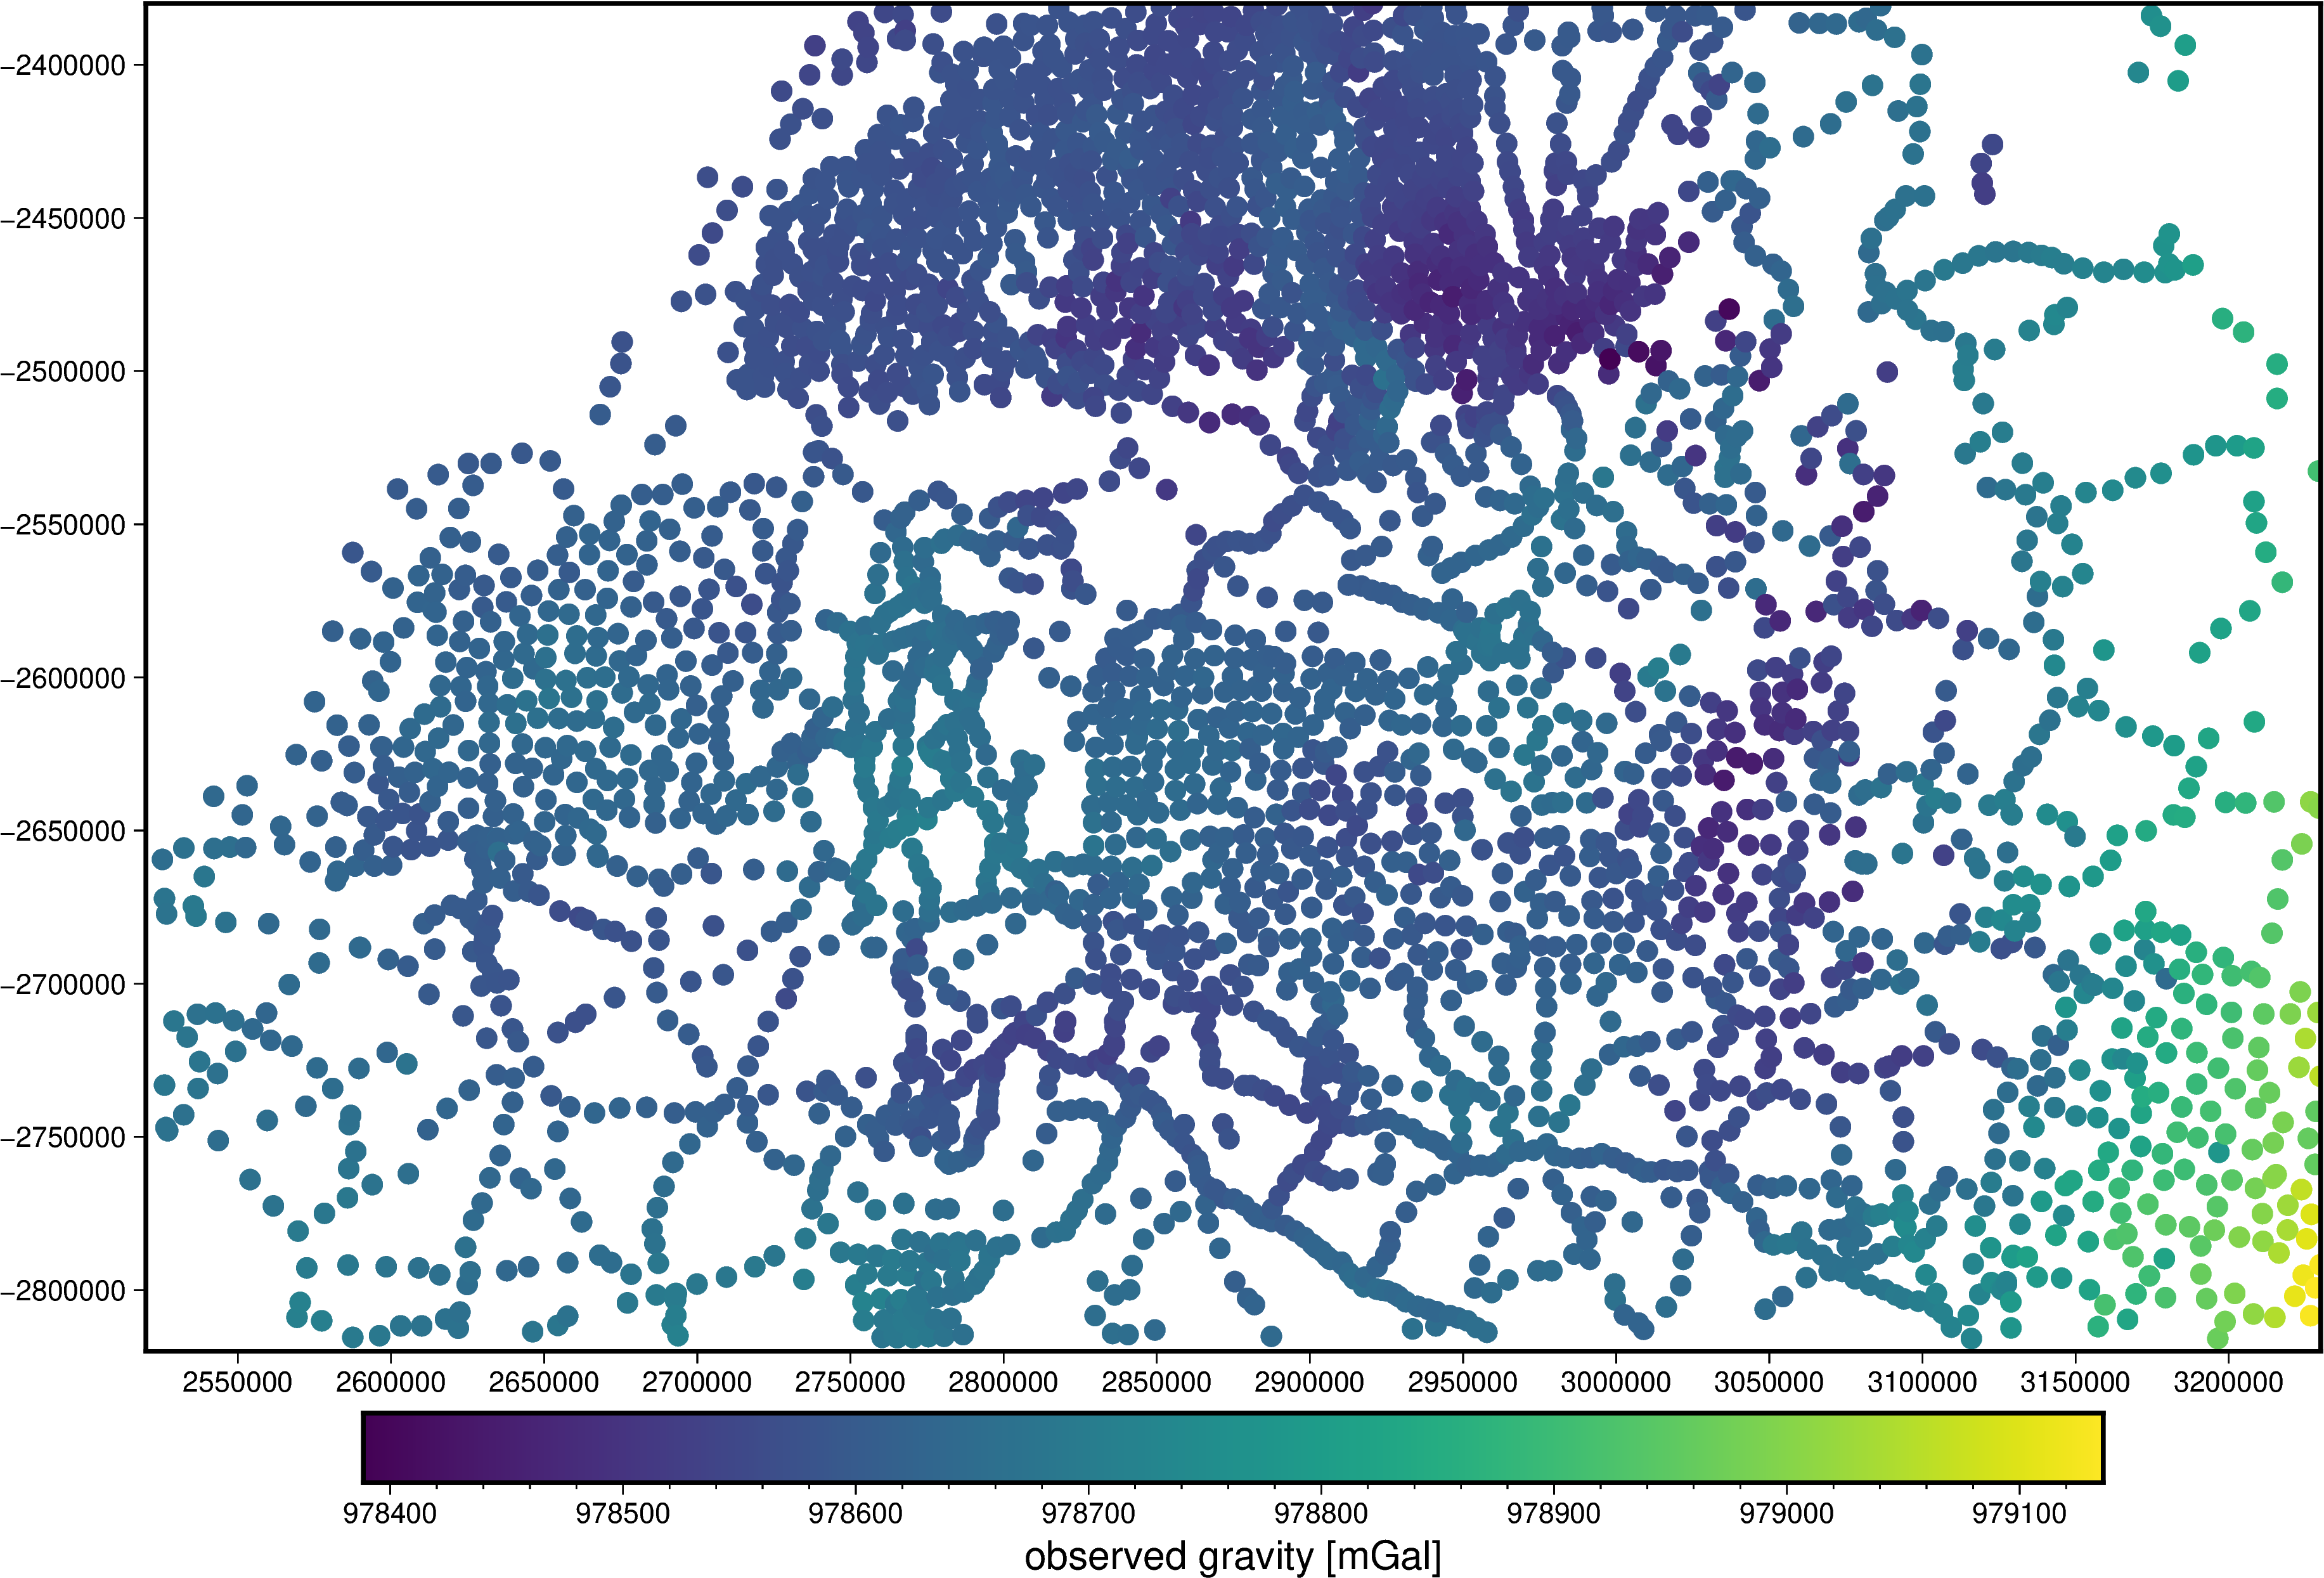

In [30]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="viridis", series=[data.gravity.min(), data.gravity.max()])
fig.plot(
    x=data.easting,
    y=data.northing,
    color=data.gravity,
    cmap=True,
    style="c8p",
    projection=fig_proj,
    region=fig_reg,
    frame=["a", "+gwhite"],
)
fig.colorbar(frame='af+l"observed gravity [mGal]"')
fig.show()

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


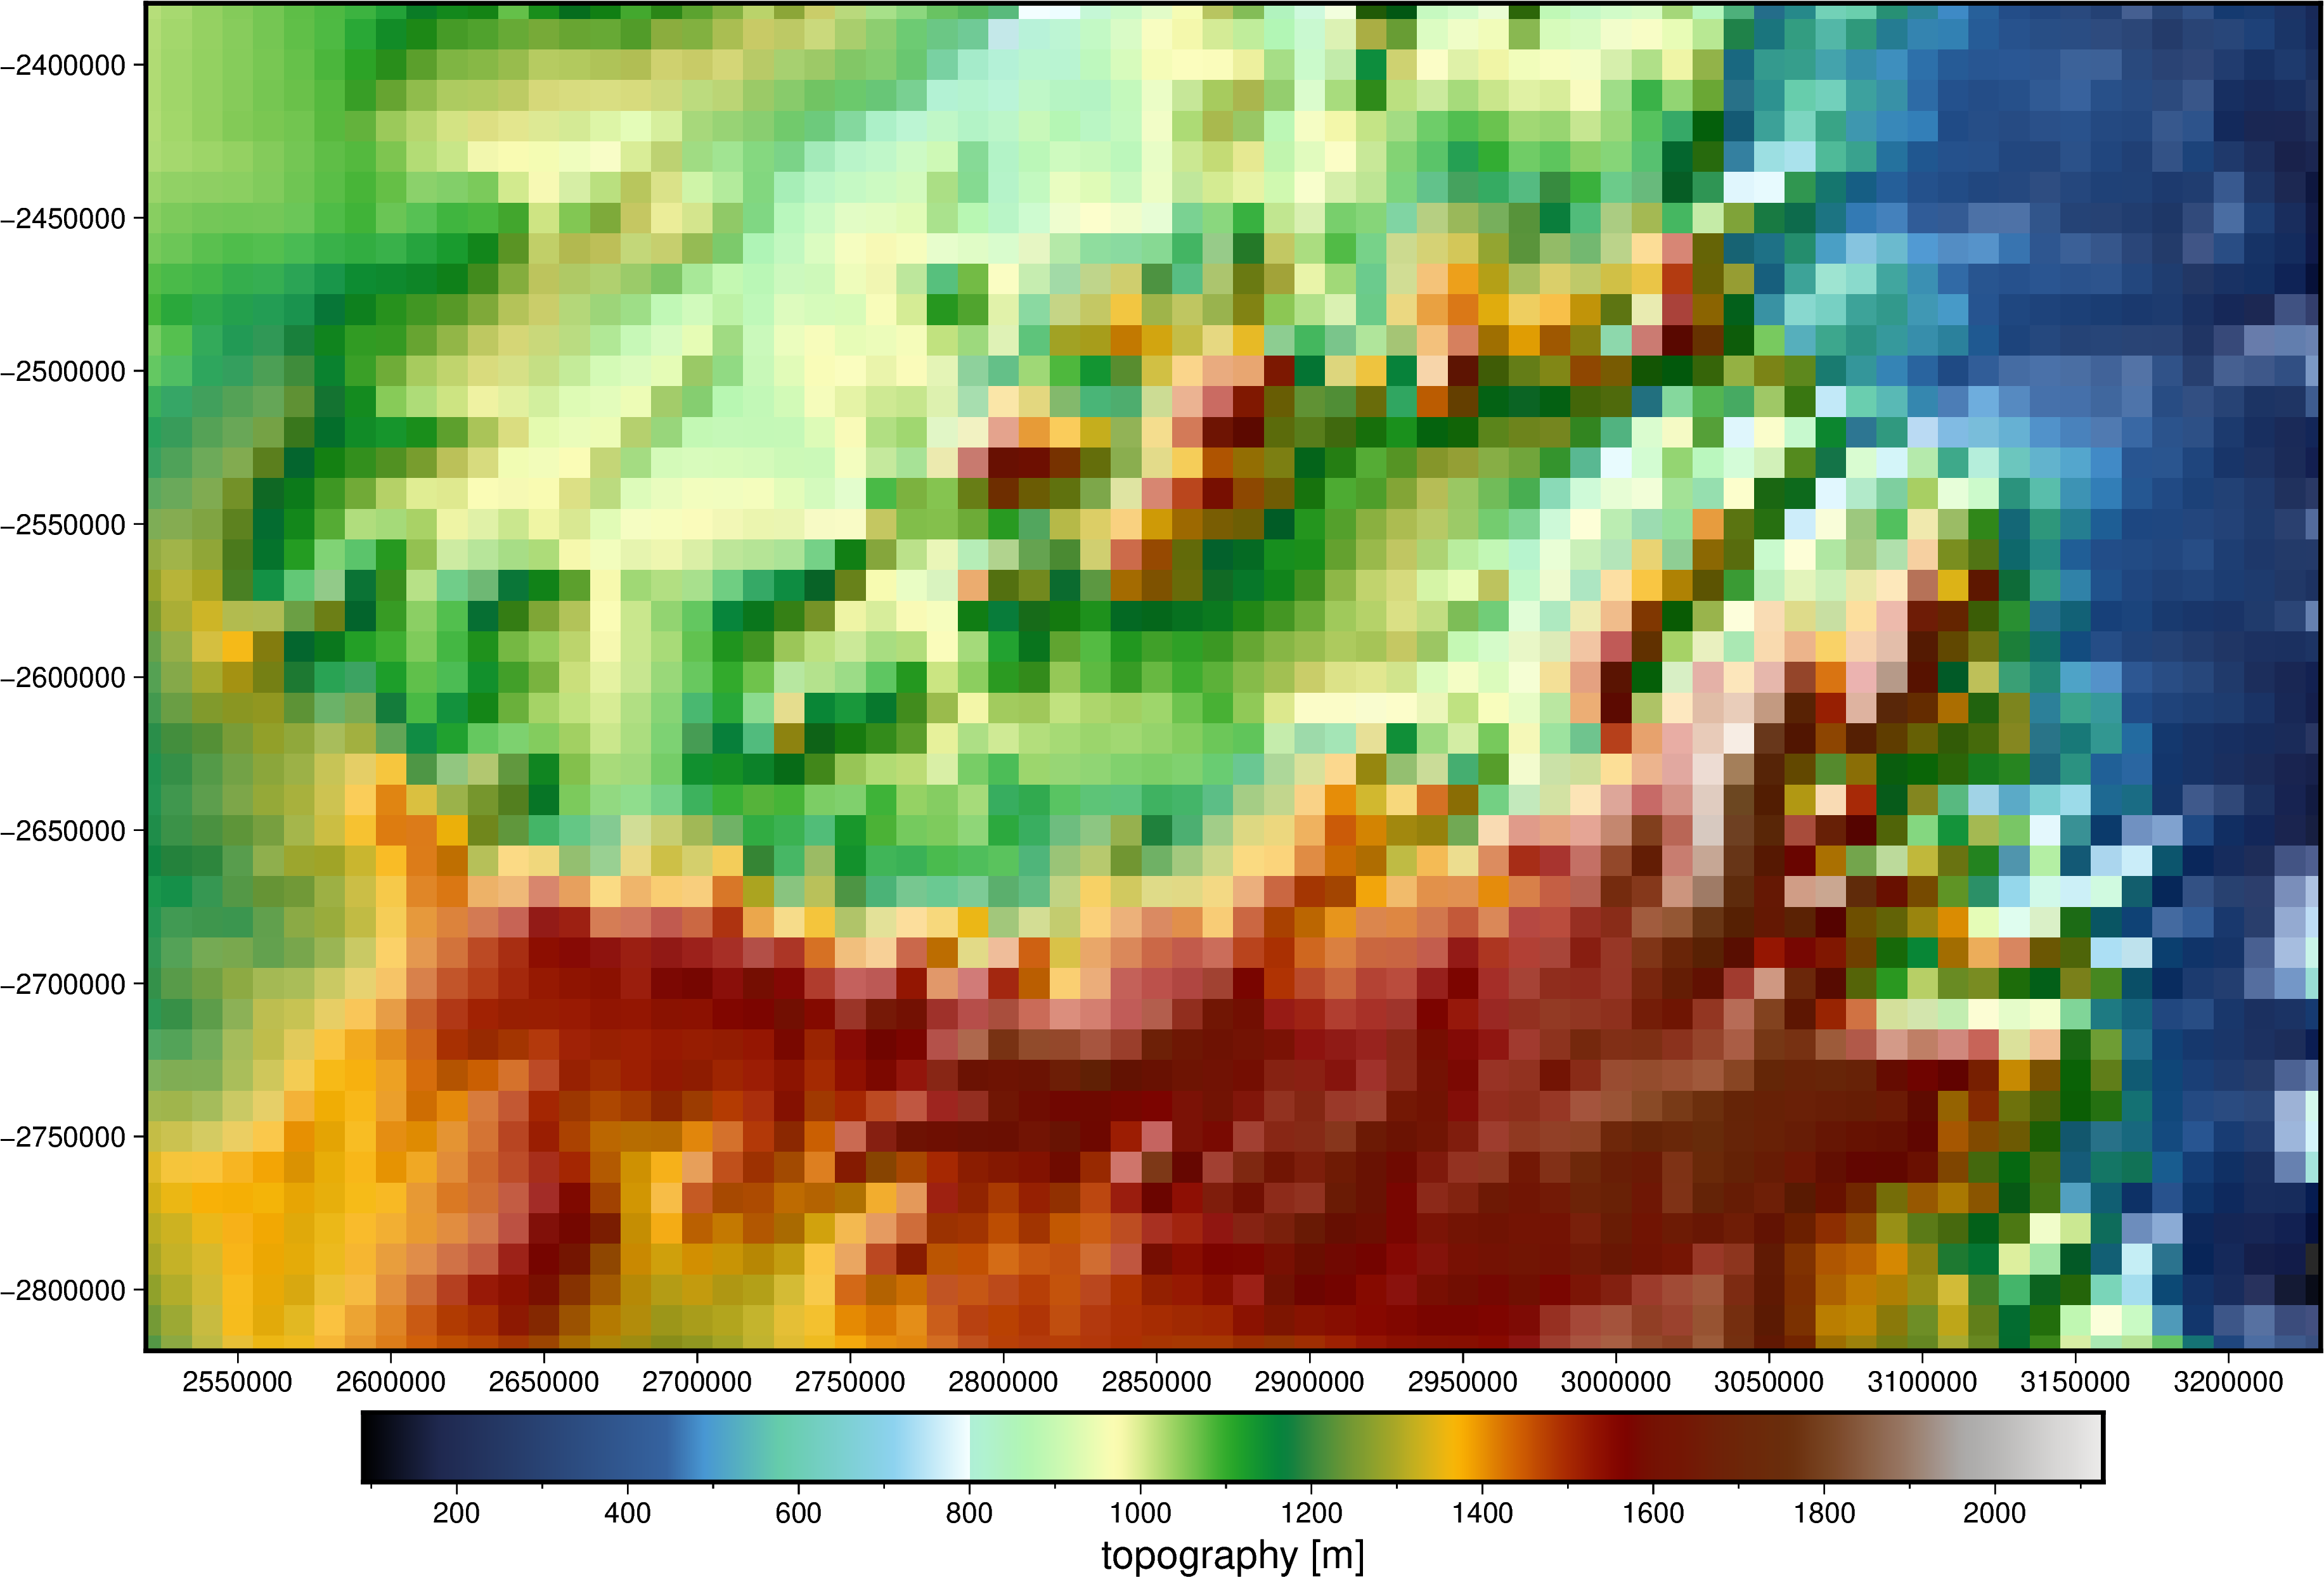

In [8]:
fig = pygmt.Figure()

pygmt.makecpt(
    cmap="earth+h800", series=[np.nanmin(da_topo.values), np.nanmax(da_topo.values)]
)
fig.grdimage(
    da_topo,
    shading=True,
    projection=fig_proj,
    frame=["a", "+gwhite"],
)
fig.colorbar(frame='af+l"topography [m]"')
fig.show()

Visualize in 3D with pyvista

C:\Users\matthewt\AppData\Local\miniforge3\envs\fatiando\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


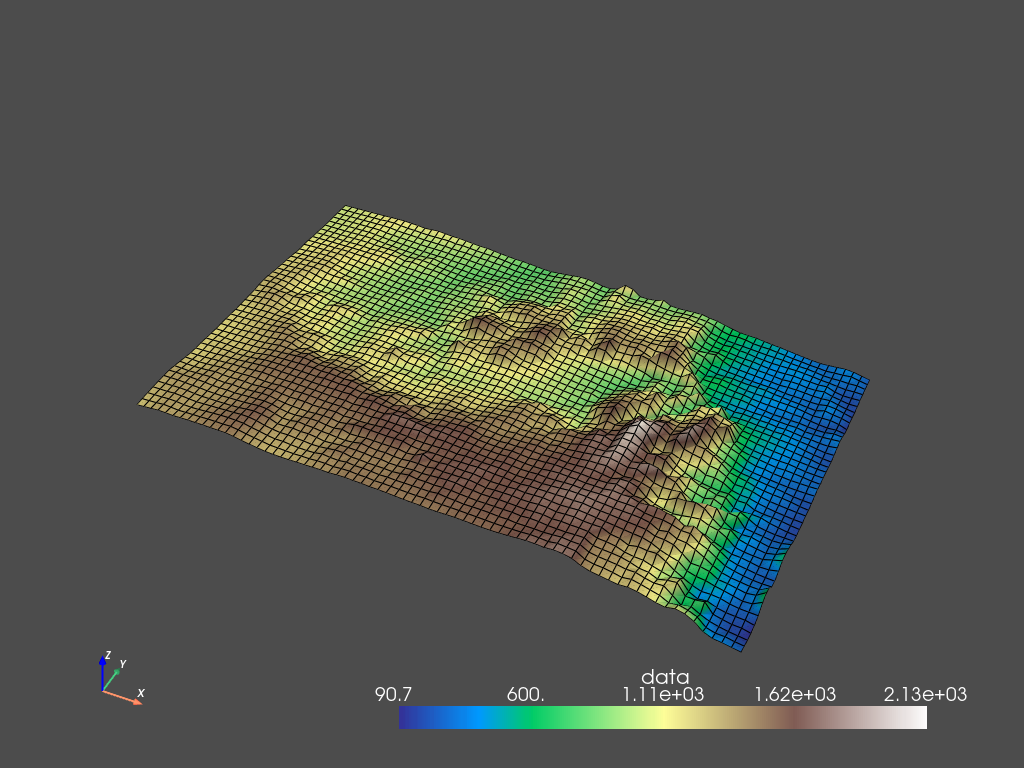

In [31]:
# plot from dataarray
data_array = da_topo
values = np.asarray(data_array)
# Make a mesh
xx, yy = np.meshgrid(data_array["x"], data_array["y"])
zz = values.reshape(xx.shape)
mesh = pyvista.StructuredGrid(xx, yy, zz)
# add data to mesh
mesh["data"] = values.reshape(mesh.n_points, -1, order="F")
# warp by elevations
warped = mesh.warp_by_scalar(factor=30)
# plot mesh
# mesh.plot(show_edges=True, cmap='terrain', cpos=(.1,-0.2,.2))
# plot warped
warped.plot(show_edges=True, cmap="terrain", cpos=(0.1, -0.2, 0.2))

# plot from dataframe
# values = df_topo.bedrock.values.reshape((len(df_topo.x.unique()), len(df_topo.y.unique()), 1))
# # Create the spatial reference
# grid = pyvista.UniformGrid()
# # Set the grid dimensions: shape + 1 because we want to inject our values on
# #   the CELL data
# grid.dimensions = np.array(values.shape) + 1
# # Edit the spatial reference
# grid.spacing = (1, 1, 10)  # These are the cell sizes along each axis
# # Add the data values to the cell data
# grid.cell_data["values"] = df_topo.bedrock#.flatten(order="F")
# # warp by the elevations
# warped = grid.cell_data_to_point_data().warp_by_scalar(factor=.005)
# # plot flat mesh
# grid.plot(show_edges=True, cmap='terrain', cpos=(.1,-0.2,.2))
# # plot warped mesh
# warped.plot(show_edges=True, cmap='terrain', cpos=(.1,-0.2,.2))

## Gravity disturbance

We can use [Boule](https://www.fatiando.org/boule) for computing the normal gravity of the WGS84 reference ellipsoid on any point.

In [32]:
ellipsoid = bl.WGS84
normal_gravity = ellipsoid.normal_gravity(data.latitude, data.elevation)
normal_gravity

0       978664.725301
1       978652.988542
2       978651.255750
3       978671.414340
4       978660.974215
            ...      
3872    978785.393559
3873    978754.230966
3874    978758.068460
3875    978807.159627
3876    978733.156141
Length: 3877, dtype: float64

And compute the gravity disturbance as the difference between the observed gravity and the normal gravity:

In [33]:
data["disturbance"] = data.gravity - normal_gravity
data

latitude  longitude  elevation    gravity       easting      northing  \
0    -26.26334   25.01500    1230.16  978681.38  2.526066e+06 -2.733052e+06   
1    -26.38713   25.01932    1297.00  978669.02  2.526503e+06 -2.746924e+06   
2    -26.39667   25.02499    1304.84  978669.28  2.527075e+06 -2.747994e+06   
3    -26.07668   25.04500    1165.24  978681.08  2.529096e+06 -2.712163e+06   
4    -26.35001   25.07668    1262.47  978665.19  2.532295e+06 -2.742763e+06   
...        ...        ...        ...        ...           ...           ...   
3872 -23.86333   31.51500     300.53  978776.85  3.182450e+06 -2.466945e+06   
3873 -23.30000   31.52499     280.72  978798.55  3.183459e+06 -2.405224e+06   
3874 -23.19333   31.54832     245.67  978803.55  3.185814e+06 -2.393567e+06   
3875 -23.84833   31.57333     226.77  978808.44  3.188340e+06 -2.465298e+06   
3876 -23.00000   31.37500     285.59  978734.77  3.168312e+06 -2.372463e+06   

      disturbance  
0       16.654699  
1       16.031458  
2       18.024250  
3        9.665660  
4        4.215785  
...           ...  
3872    -8.543559  
3873    44.319034  
3874    45.481540  
3875     1.280373  
3876     1.613859  

[3877 rows x 7 columns]

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


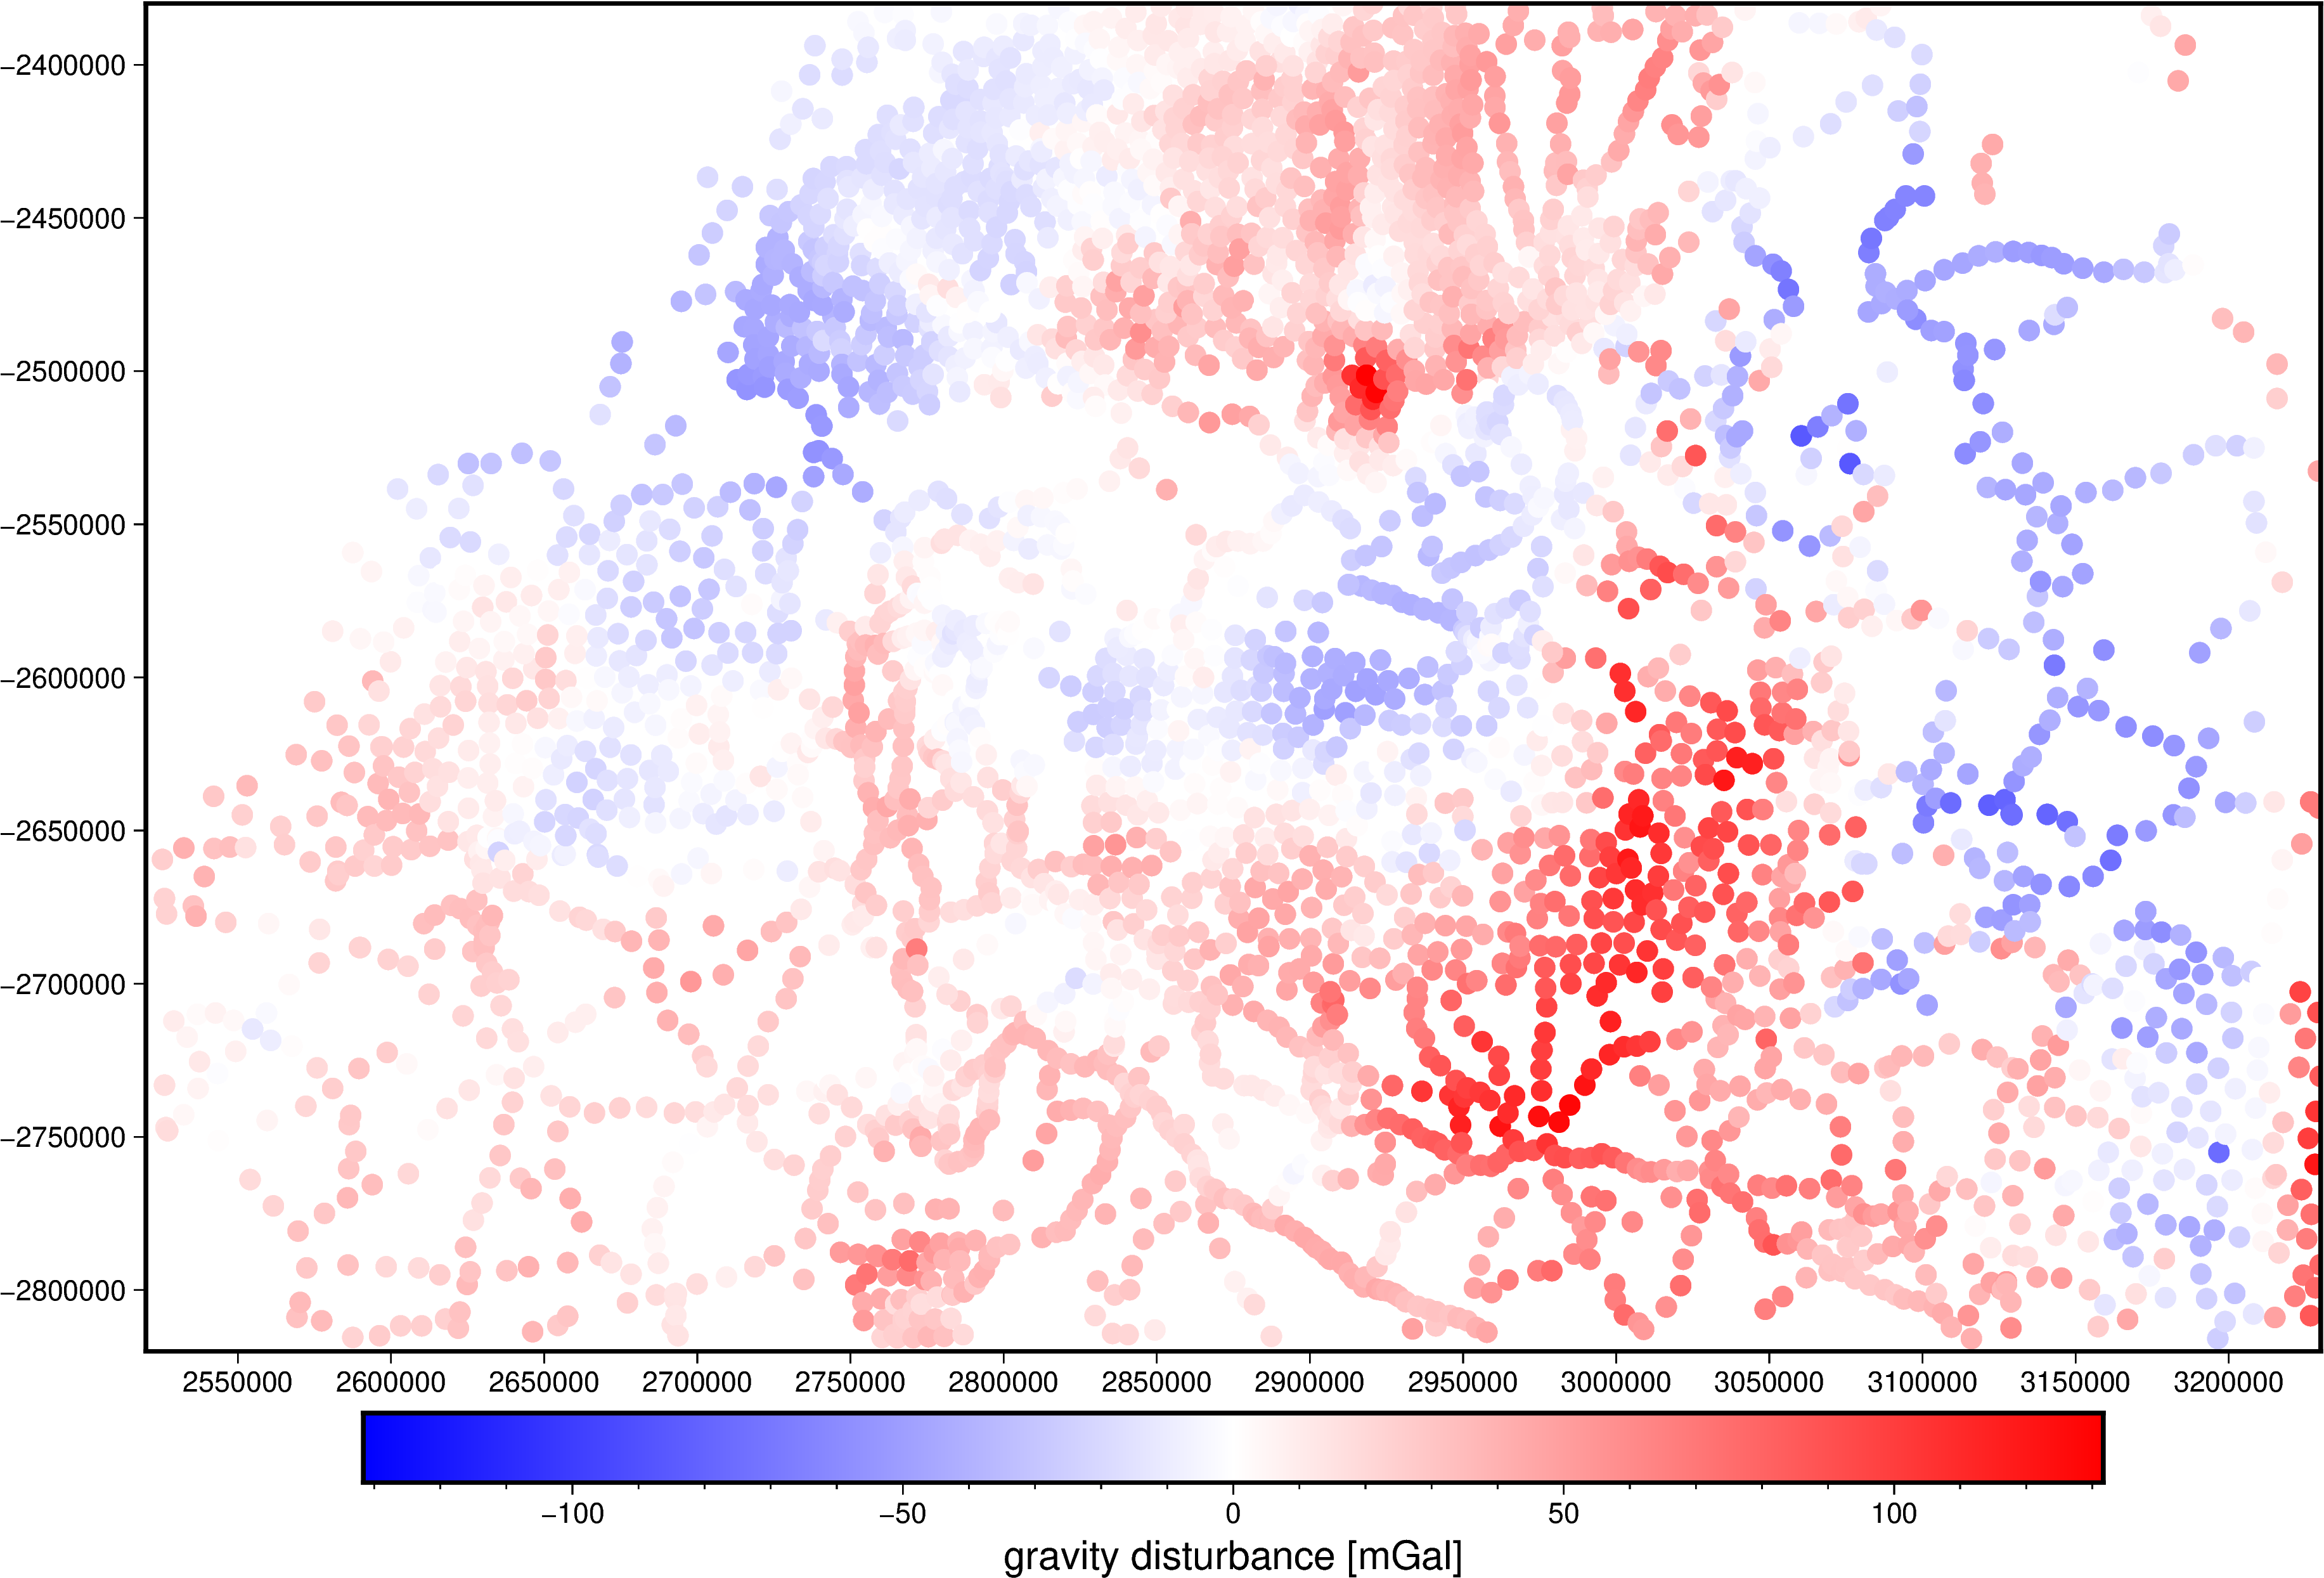

In [34]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.disturbance)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.easting,
    y=data.northing,
    color=data.disturbance,
    cmap=True,
    style="c8p",
    projection=fig_proj,
    frame=["a", "+gwhite"],
)

fig.colorbar(frame='af+l"gravity disturbance [mGal]"')
fig.show()

## Topographic correction

We can use [Harmonica](https://www.fatiando.org/harmonica) for forward modelling the gravitational effect of the terrain through rectangular prisms.

First, define a layer of prisms from the topography grid.

In [35]:
topo_prisms = hm.prism_layer(
    coordinates=(da_topo.x.values, da_topo.y.values),
    surface=da_topo.values,
    reference=-10000,
    properties={"density": 2670 * np.ones_like(da_topo)},
)
topo_prisms

<xarray.Dataset>
Dimensions:   (northing: 45, easting: 72)
Coordinates:
  * easting   (easting) float64 2.52e+06 2.53e+06 2.54e+06 ... 3.22e+06 3.23e+06
  * northing  (northing) float64 -2.82e+06 -2.81e+06 ... -2.39e+06 -2.38e+06
    top       (northing, easting) float32 1.214e+03 1.257e+03 ... 278.8 222.3
    bottom    (northing, easting) float64 -1e+04 -1e+04 -1e+04 ... -1e+04 -1e+04
Data variables:
    density   (northing, easting) float32 2.67e+03 2.67e+03 ... 2.67e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

Visualize the prism model

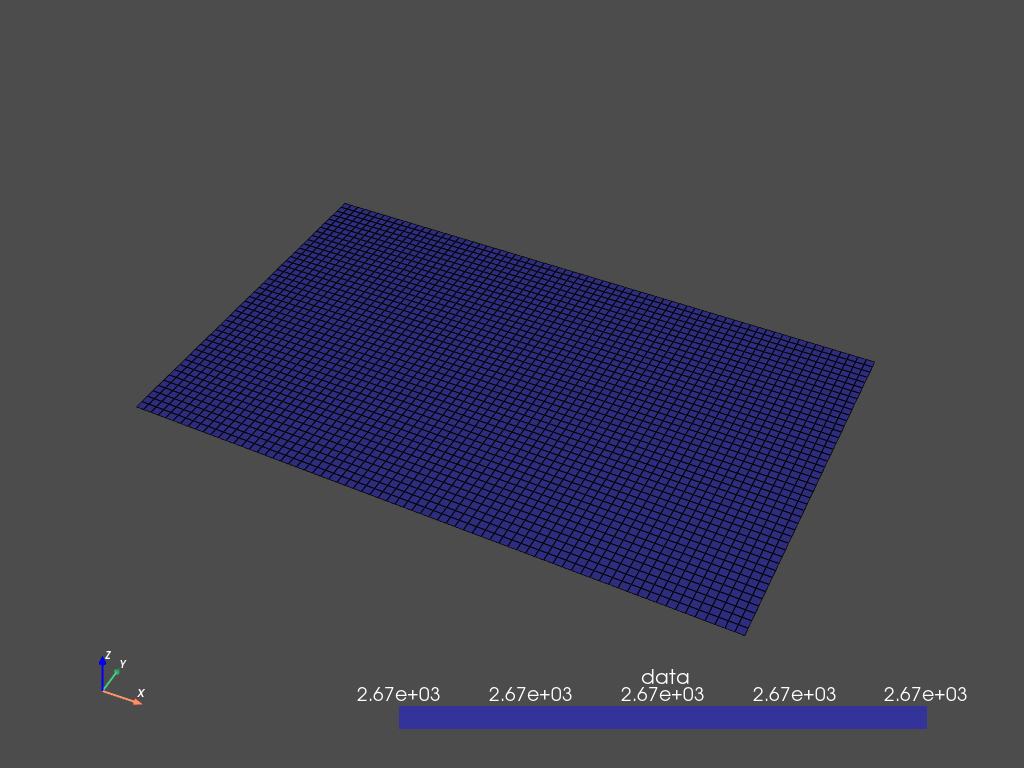

In [47]:
# plot from dataarray
data_array = topo_prisms.to_array()
values = np.asarray(data_array)
# Make a mesh
xx, yy = np.meshgrid(data_array["easting"], data_array["northing"])
zz = values.reshape(xx.shape)
mesh = pyvista.StructuredGrid(xx, yy, zz)
# add data to mesh
mesh["data"] = values.reshape(mesh.n_points, -1, order="F")
# plot mesh
mesh.plot(show_edges=True, cmap="terrain", cpos=(0.1, -0.2, 0.2))

# # plot from dataframe
# df_topo_prisms=topo_prisms.to_dataframe().reset_index()
# points=df_topo_prisms[['easting', 'northing', 'top']]
# points.top.values
# # values = np.linspace(0, 3239, 3240).reshape((72, 45, 1))
# values = points.top.values.reshape((topo_prisms.easting.shape[0],
#                                     topo_prisms.northing.shape[0], 1))
# # Create the spatial reference
# grid = pyvista.UniformGrid()
# # Set the grid dimensions: shape + 1 because we want to inject our values on
# #   the CELL data
# grid.dimensions = np.array(values.shape) + 1
# # Edit the spatial reference
# # grid.origin = (100, 33, 55.6)  # The bottom left corner of the data set
# grid.spacing = (1, 1, 1)  # These are the cell sizes along each axis
# # Add the data values to the cell data
# grid.cell_data["values"] = points.top#.flatten(order="F")
# grid.plot(show_edges=True, cmap='terrain', cpos=(.1,-0.2,.2))

Second, forward model the gravitational effect of the terrain at the data points.

In [48]:
%%time

coordinates = (data.easting, data.northing, data.elevation)
terrain_effect = topo_prisms.prism_layer.gravity(coordinates, field="g_z")
terrain_effect

CPU times: total: 7.17 s
Wall time: 2.38 s


array([1062.38184124, 1069.99475357, 1077.88250843, ..., 1019.32959553,
       1085.59464482,  341.32050751])

Calculate the Bouguer disturbance (topography-free).

In [49]:
data["bouguer"] = data.disturbance - terrain_effect
data

latitude  longitude  elevation    gravity       easting      northing  \
0    -26.26334   25.01500    1230.16  978681.38  2.526066e+06 -2.733052e+06   
1    -26.38713   25.01932    1297.00  978669.02  2.526503e+06 -2.746924e+06   
2    -26.39667   25.02499    1304.84  978669.28  2.527075e+06 -2.747994e+06   
3    -26.07668   25.04500    1165.24  978681.08  2.529096e+06 -2.712163e+06   
4    -26.35001   25.07668    1262.47  978665.19  2.532295e+06 -2.742763e+06   
...        ...        ...        ...        ...           ...           ...   
3872 -23.86333   31.51500     300.53  978776.85  3.182450e+06 -2.466945e+06   
3873 -23.30000   31.52499     280.72  978798.55  3.183459e+06 -2.405224e+06   
3874 -23.19333   31.54832     245.67  978803.55  3.185814e+06 -2.393567e+06   
3875 -23.84833   31.57333     226.77  978808.44  3.188340e+06 -2.465298e+06   
3876 -23.00000   31.37500     285.59  978734.77  3.168312e+06 -2.372463e+06   

      disturbance      bouguer  
0       16.654699 -1045.727143  
1       16.031458 -1053.963296  
2       18.024250 -1059.858258  
3        9.665660 -1078.601878  
4        4.215785 -1114.367453  
...           ...          ...  
3872    -8.543559 -1107.475435  
3873    44.319034 -1014.272237  
3874    45.481540  -973.848055  
3875     1.280373 -1084.314271  
3876     1.613859  -339.706649  

[3877 rows x 8 columns]

Plot it with pygmt.

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


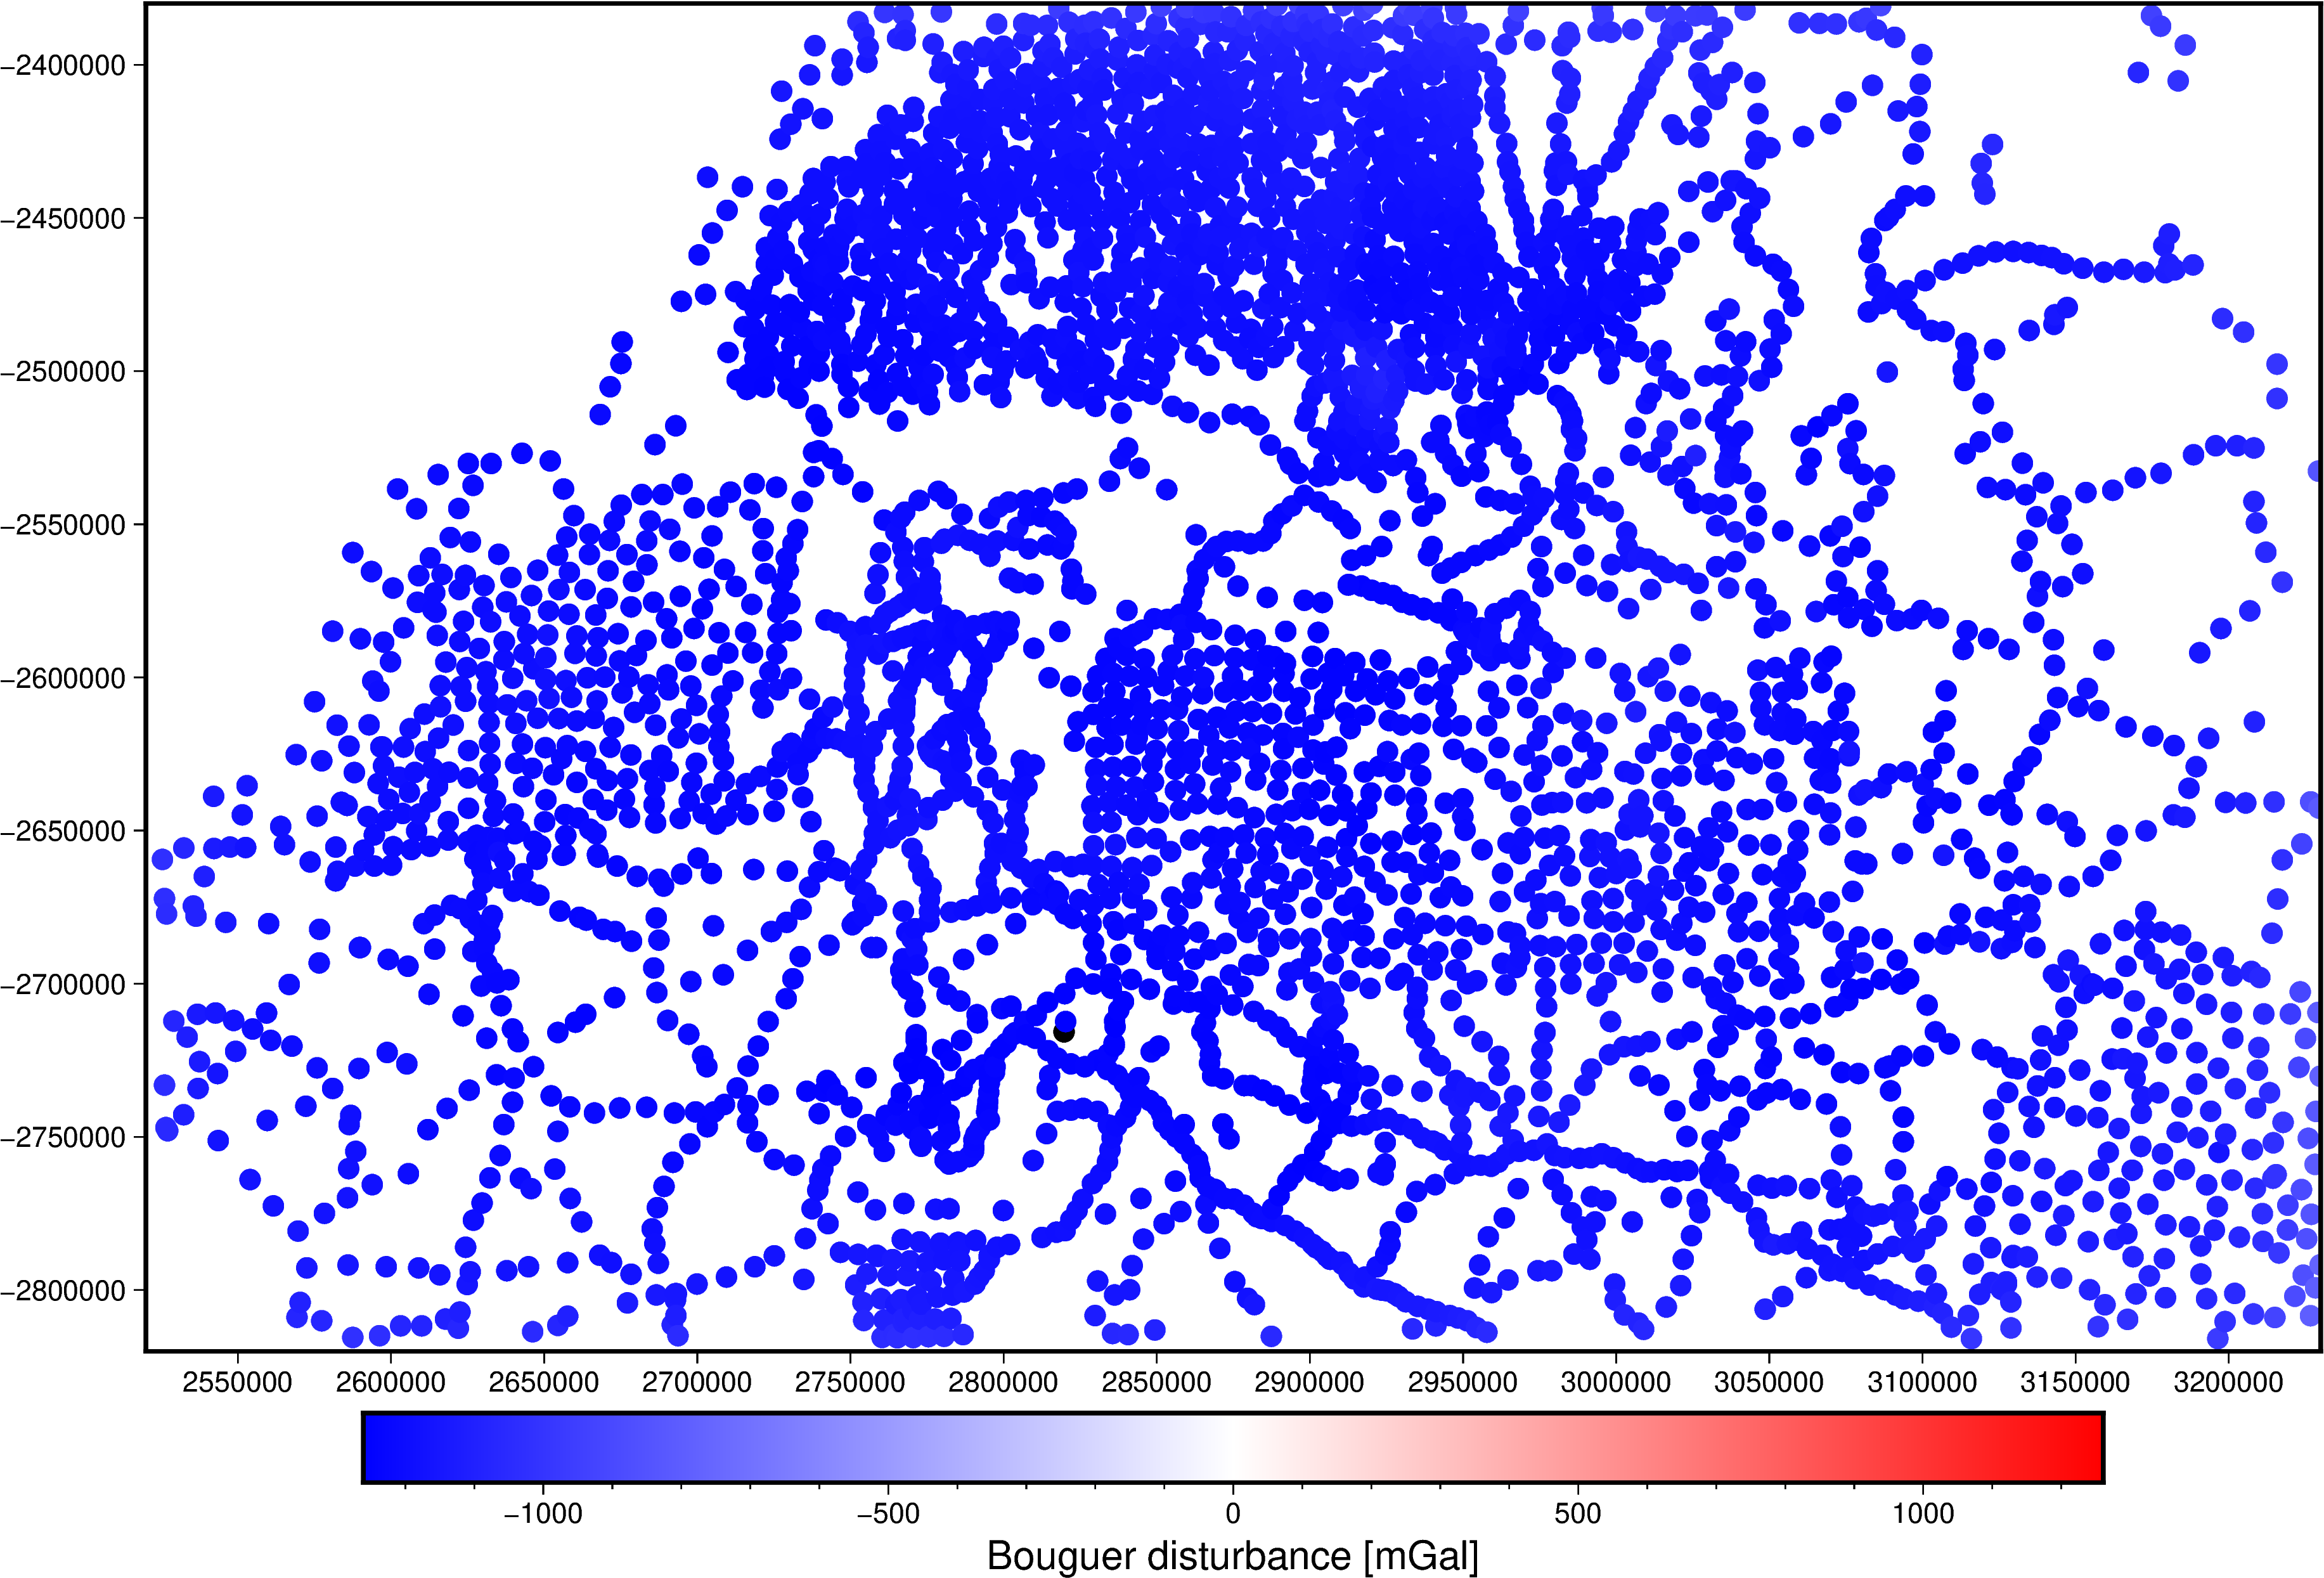

In [50]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.bouguer)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.easting,
    y=data.northing,
    color=data.bouguer,
    cmap=True,
    style="c8p",
    projection=fig_proj,
    frame=["a", "+gwhite"],
)
fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
fig.show()

## Regional-residual separation

We can use [Verde](https://www.fatiando.org/verde) to remove a second degree trend from the Bouguer disturbance.

In [51]:
trend = vd.Trend(degree=2).fit(coordinates, data.bouguer)

data["residuals"] = data.bouguer - trend.predict(coordinates)
data

latitude  longitude  elevation    gravity       easting      northing  \
0    -26.26334   25.01500    1230.16  978681.38  2.526066e+06 -2.733052e+06   
1    -26.38713   25.01932    1297.00  978669.02  2.526503e+06 -2.746924e+06   
2    -26.39667   25.02499    1304.84  978669.28  2.527075e+06 -2.747994e+06   
3    -26.07668   25.04500    1165.24  978681.08  2.529096e+06 -2.712163e+06   
4    -26.35001   25.07668    1262.47  978665.19  2.532295e+06 -2.742763e+06   
...        ...        ...        ...        ...           ...           ...   
3872 -23.86333   31.51500     300.53  978776.85  3.182450e+06 -2.466945e+06   
3873 -23.30000   31.52499     280.72  978798.55  3.183459e+06 -2.405224e+06   
3874 -23.19333   31.54832     245.67  978803.55  3.185814e+06 -2.393567e+06   
3875 -23.84833   31.57333     226.77  978808.44  3.188340e+06 -2.465298e+06   
3876 -23.00000   31.37500     285.59  978734.77  3.168312e+06 -2.372463e+06   

      disturbance      bouguer   residuals  
0       16.654699 -1045.727143   80.488416  
1       16.031458 -1053.963296   61.181002  
2       18.024250 -1059.858258   54.668378  
3        9.665660 -1078.601878   63.875558  
4        4.215785 -1114.367453    7.363263  
...           ...          ...         ...  
3872    -8.543559 -1107.475435  -44.144727  
3873    44.319034 -1014.272237  -29.528410  
3874    45.481540  -973.848055   -8.073075  
3875     1.280373 -1084.314271  -26.342360  
3876     1.613859  -339.706649  602.834217  

[3877 rows x 9 columns]

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


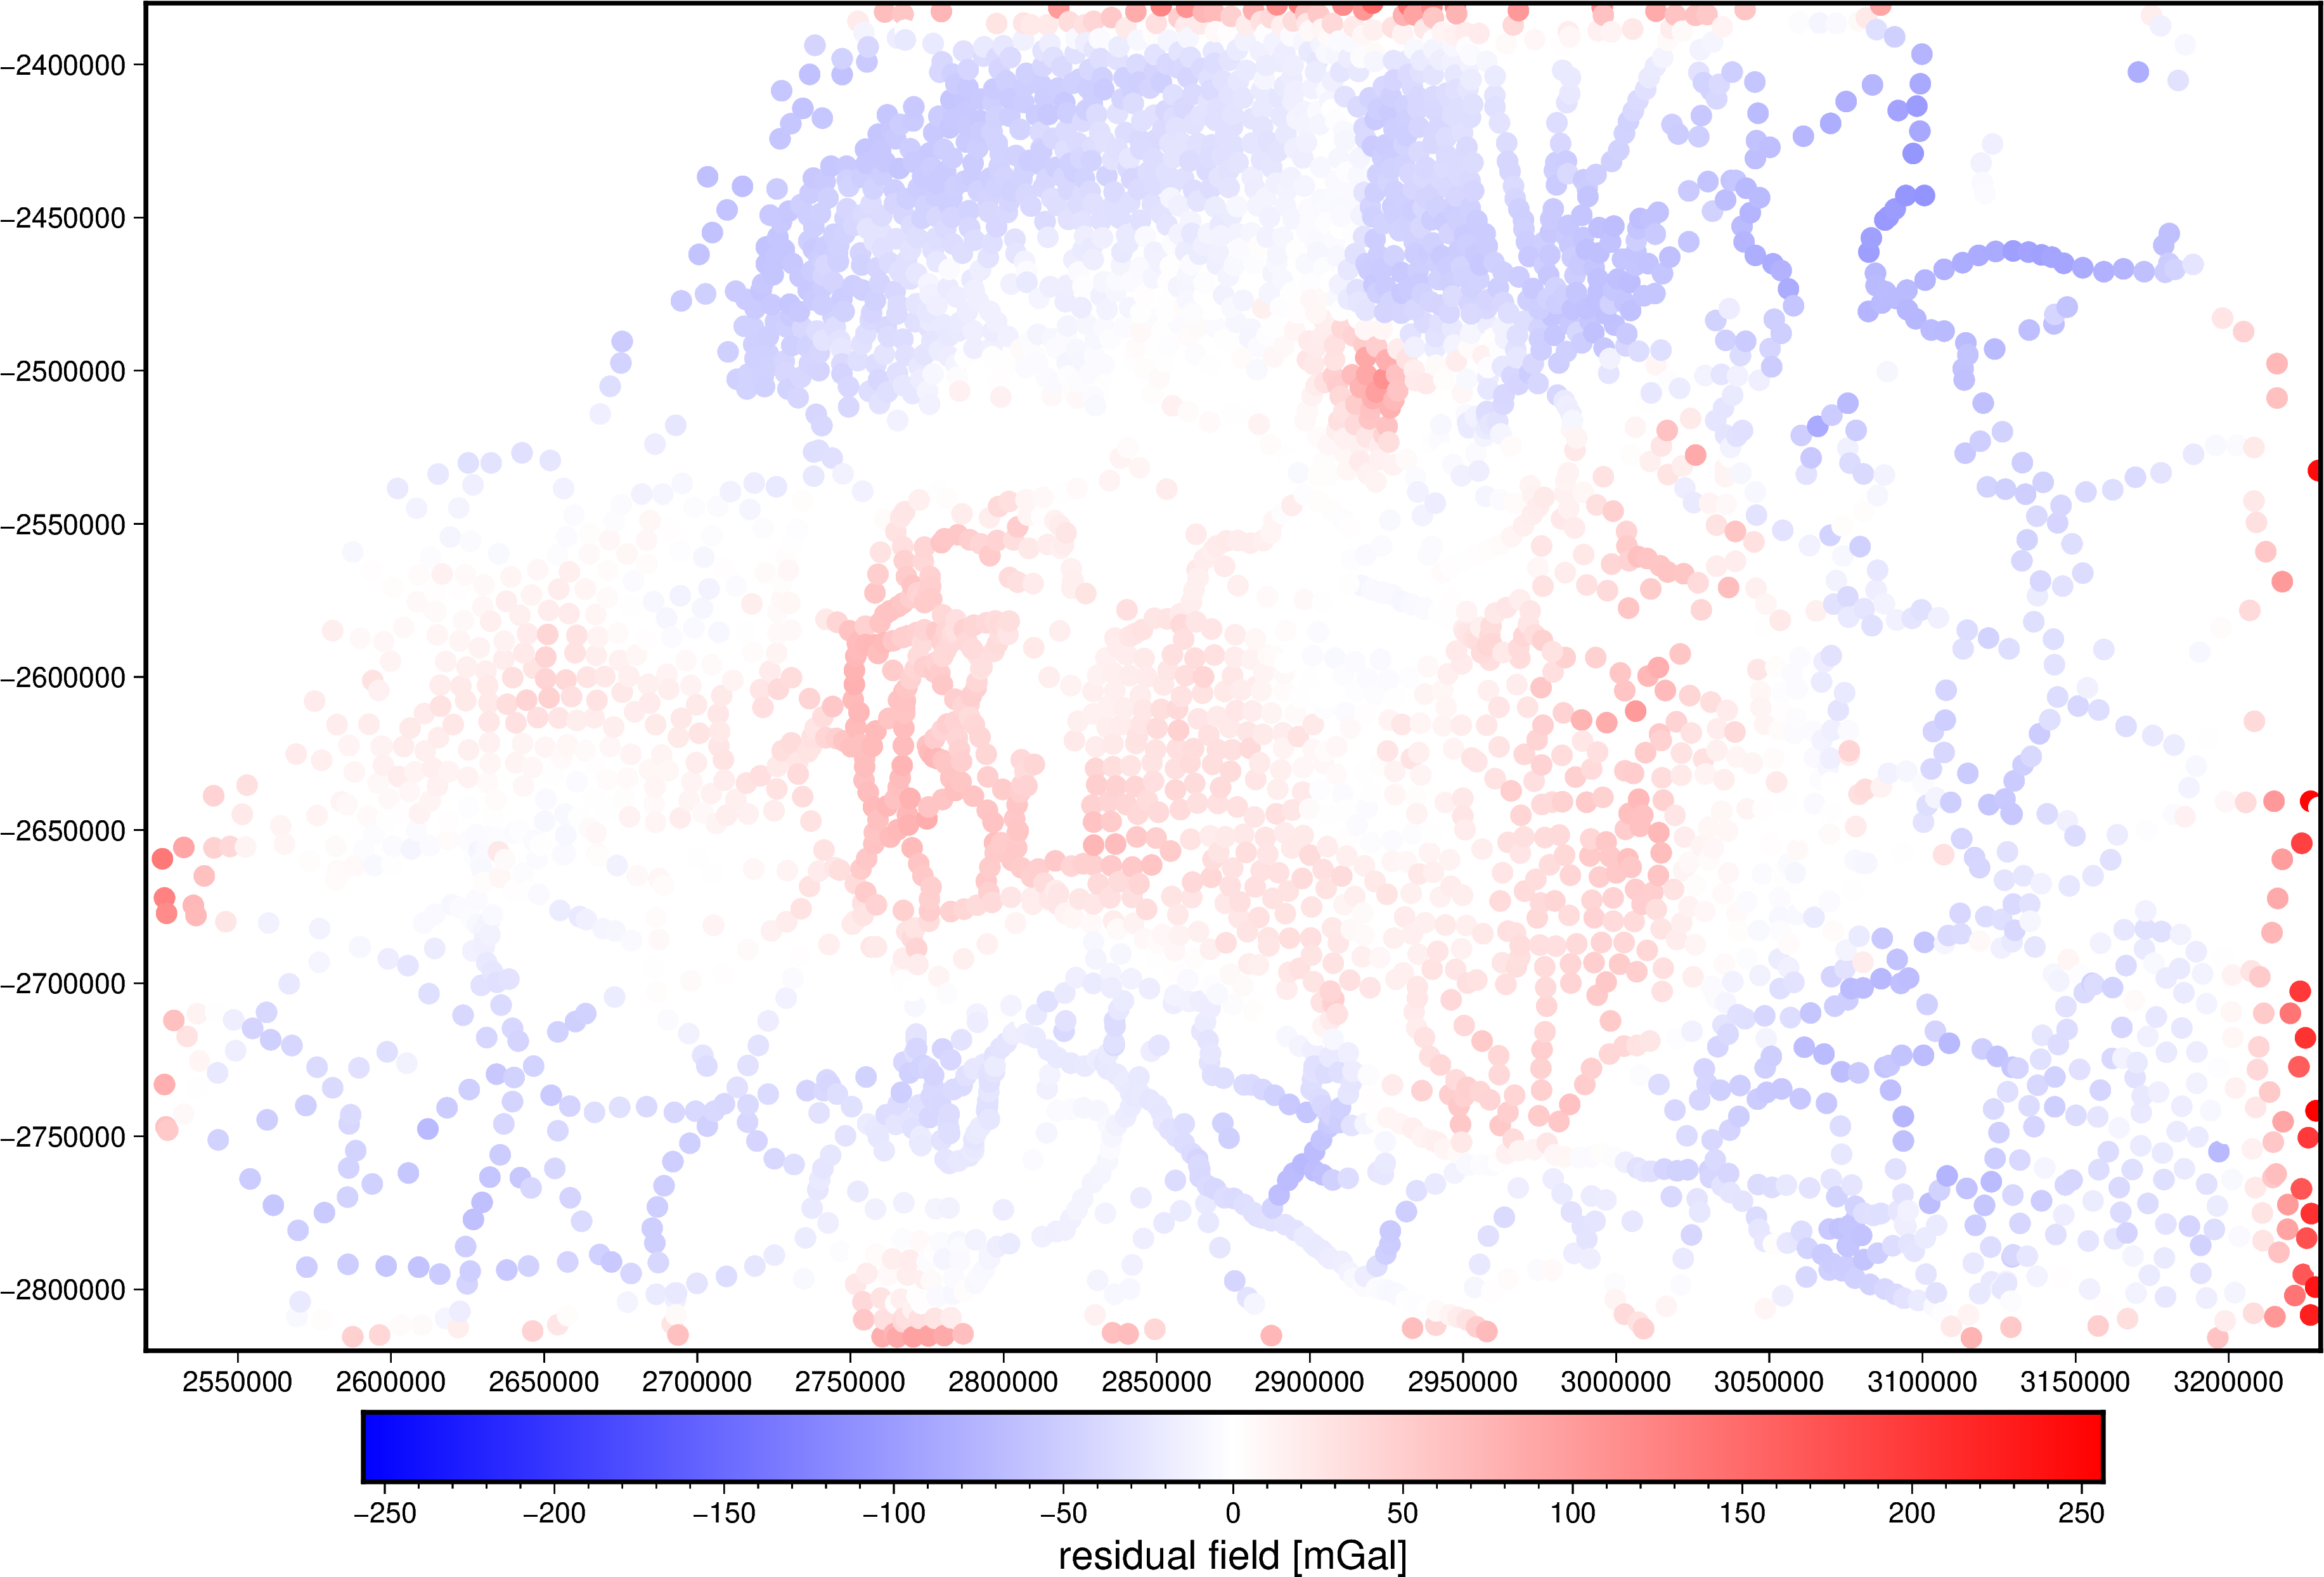

In [52]:
fig = pygmt.Figure()
maxabs = np.quantile(np.abs(data.residuals), 0.99)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.easting,
    y=data.northing,
    color=data.residuals,
    cmap=True,
    style="c8p",
    projection=fig_proj,
    frame=["a", "+gwhite"],
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.show()

## Grid the residuals with Equivalent Sources

Use the equivalent sources implementation in Harmonica to grid the residuals and upward-continue them to the same height (all in one step).

In [53]:
%%time

eql = hm.EQLHarmonic(damping=100, relative_depth=10e3)
eql.fit(coordinates, data.residuals)

CPU times: total: 6.45 s
Wall time: 2.19 s


EQLHarmonic(damping=100, depth=10000.0)

Use the source model to forward model the grid at a uniform height. We can use the projection to generate a grid in **geographic coordinates** instead of Cartesian.

In [54]:
%%time

region = vd.get_region((data.easting, data.northing))

grid = eql.grid(
    upward=2200,
    region=region,
    spacing=1000,
    data_names=["residuals"],
    dims=("northing", "easting"),
)

grid

CPU times: total: 7.55 s
Wall time: 1.52 s


<xarray.Dataset>
Dimensions:    (northing: 444, easting: 706)
Coordinates:
  * easting    (easting) float64 2.525e+06 2.526e+06 ... 3.23e+06 3.231e+06
  * northing   (northing) float64 -2.816e+06 -2.815e+06 ... -2.372e+06
    upward     (northing, easting) float64 2.2e+03 2.2e+03 ... 2.2e+03 2.2e+03
Data variables:
    residuals  (northing, easting) float64 0.5754 0.3718 0.1666 ... 48.29 47.82
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100, depth=10000.0)

Plot the gridded residuals.

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


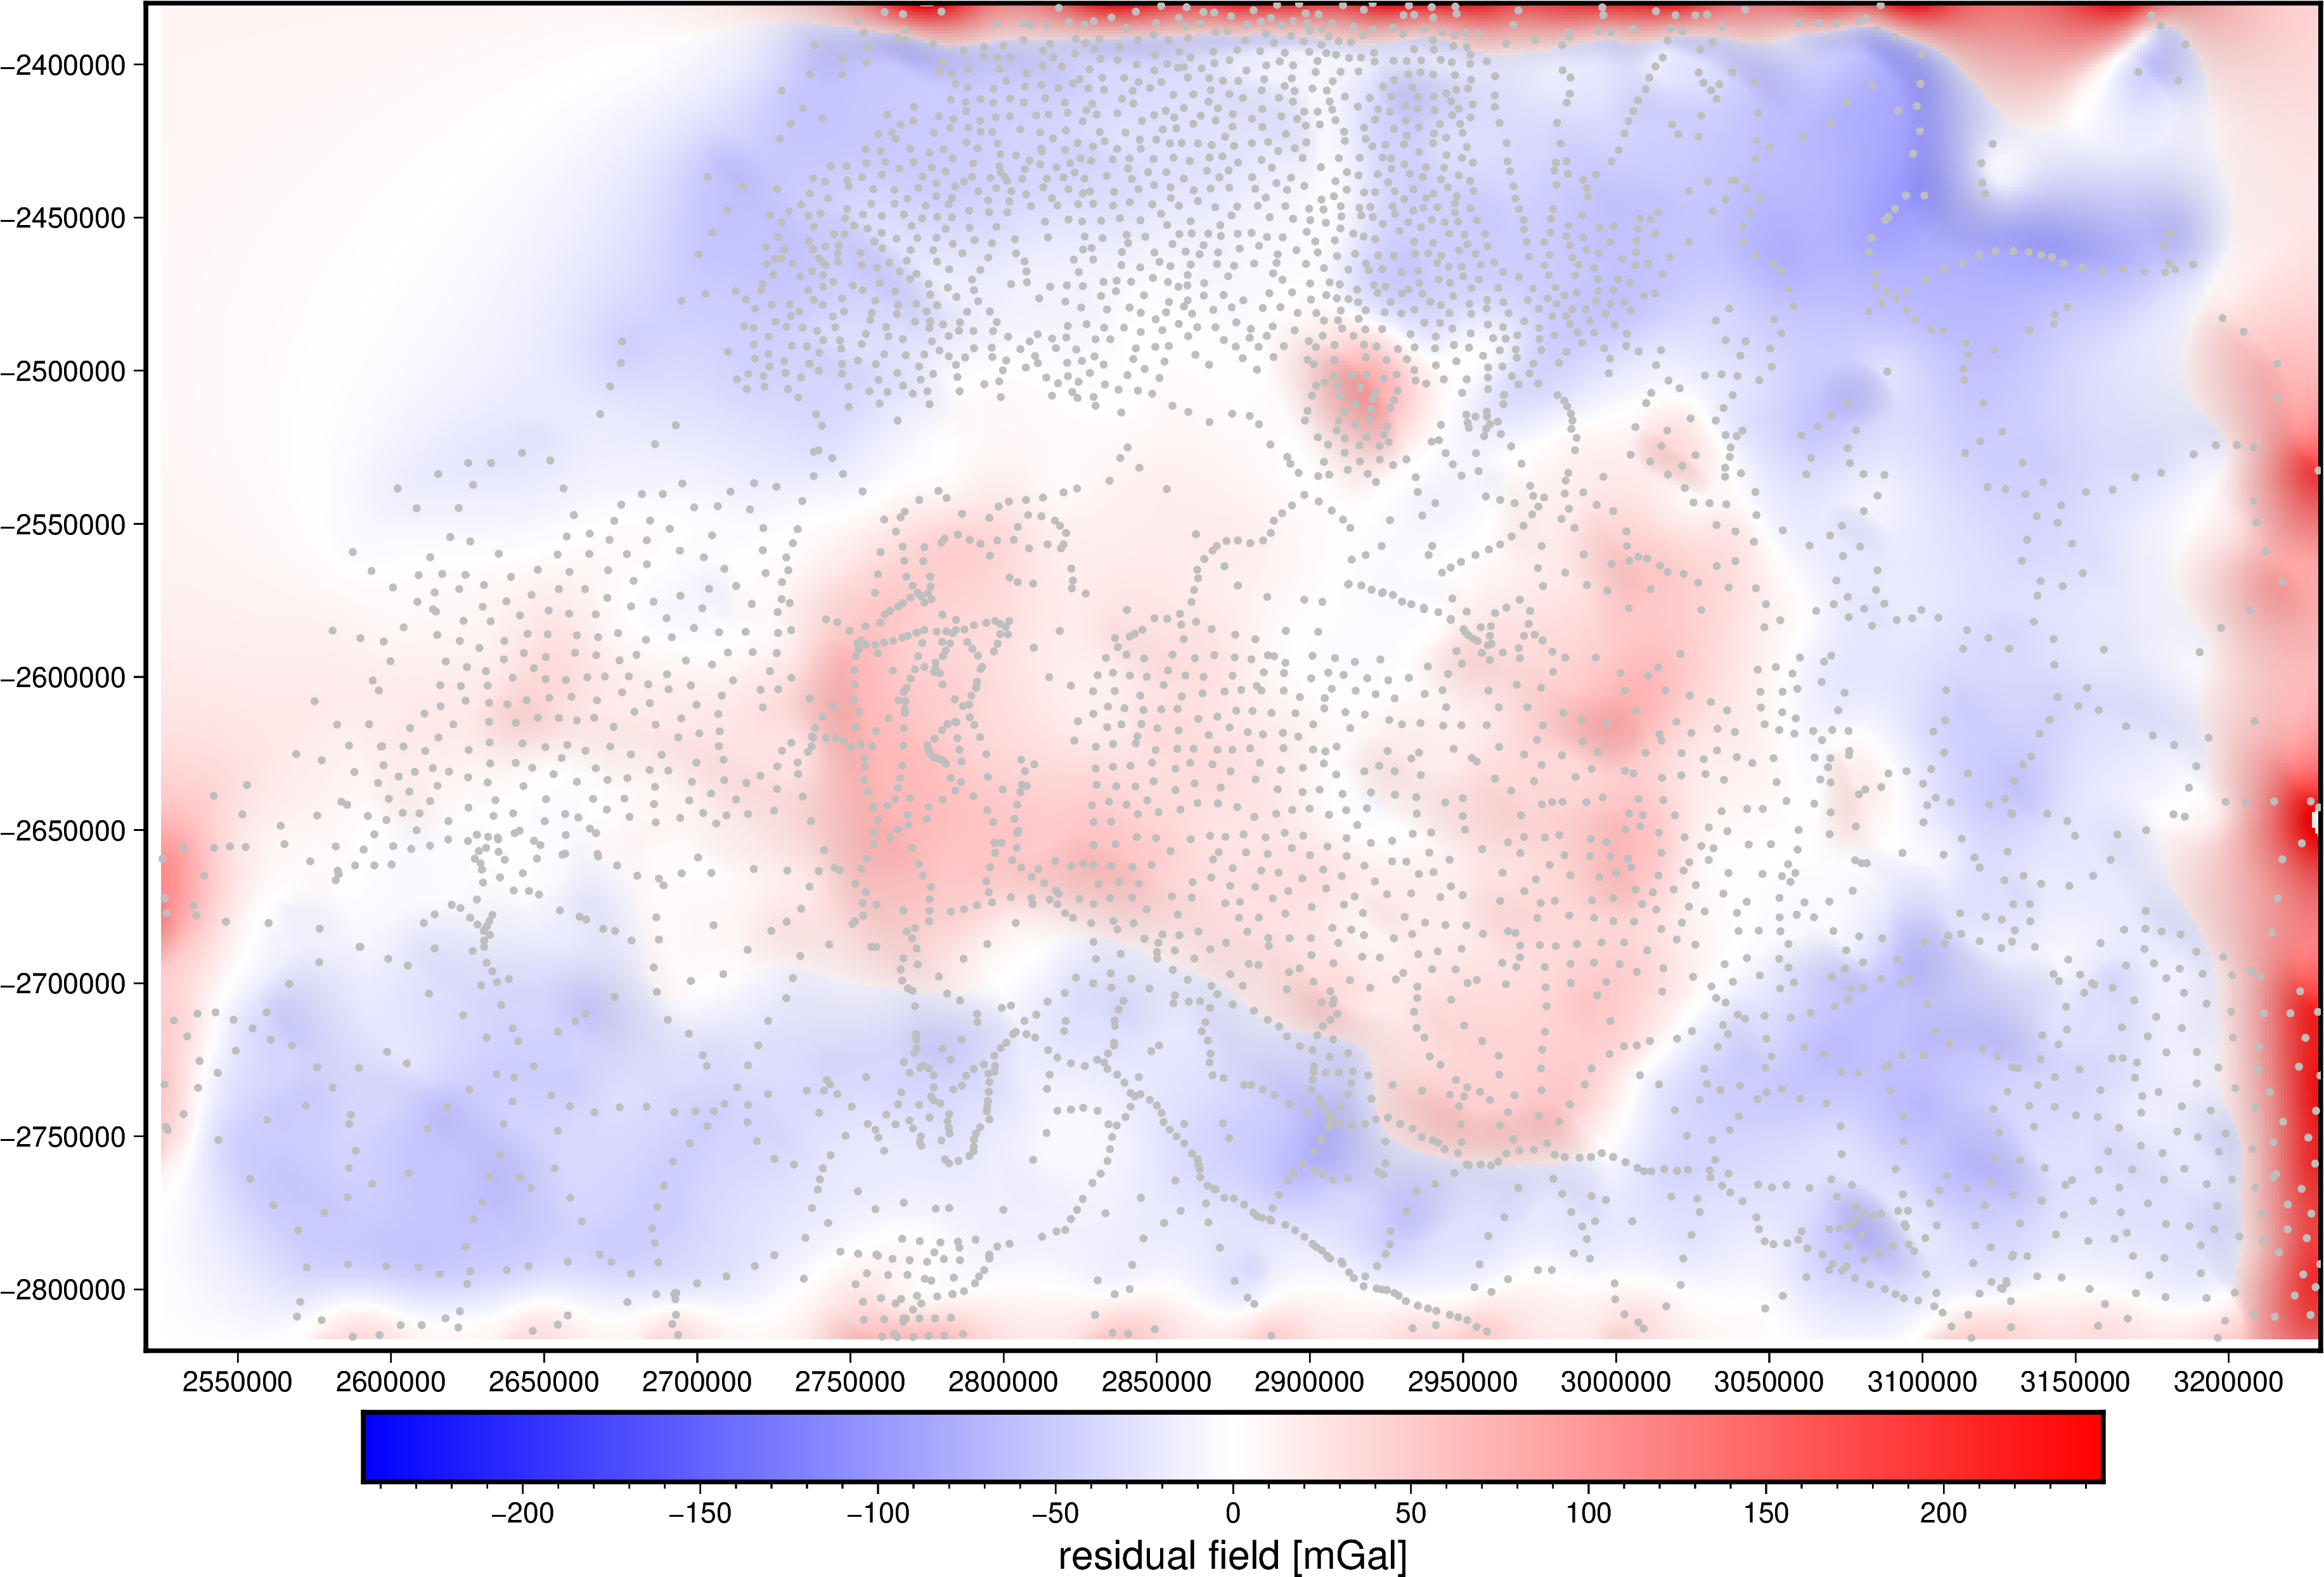

In [55]:
fig = pygmt.Figure()
scale = np.quantile(np.abs(grid.residuals), 0.995)
pygmt.makecpt(cmap="polar", series=[-scale, scale], no_bg=True)
fig.grdimage(
    grid.residuals,
    shading="+a45+nt0.15",
    cmap=True,
    projection=fig_proj,
    frame=["a", "+gwhite"],
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.easting,
    y=data.northing,
    style="c0.1c",
    color="gray",
)
fig.show()

In [ ]:
from numpy.lib.stride_tricks import as_strided

block = 1000
a = df_topo[["northing", "easting", "bedrock"]].to_numpy()


def bucket(x, bucket_size):
    x = np.ascontiguousarray(x)
    oldshape = np.array(x.shape)
    newshape = np.concatenate((oldshape // bucket_size, bucket_size))
    oldstrides = np.array(x.strides)
    newstrides = np.concatenate((oldstrides * bucket_size, oldstrides))
    axis = tuple(range(x.ndim, 2 * x.ndim))
    return as_strided(x, newshape, newstrides).mean(axis)


a_block = bucket(a, (block, 1))
print(a_block.shape)

In [ ]:
elev = np.take(a_block, indices=[-1], axis=1)
elev

In [ ]:
topo3d = pyvista.UniformGrid(
    dims=(a_block.shape[0], a_block.shape[0], 1),
    spacing=(
        (df_topo.northing.max() - df_topo.northing.min()) // block,
        (df_topo.easting.max() - df_topo.easting.min()) // block,
        0,
    ),
)
# topo3d.field_data['elev'] = np.take(a_block,indices=[-1],axis=1)
topo3d.plot(show_edges=True, show_grid=True)  # , cmap='gist_earth', scalars='elev')